In [3]:

# Google Colab GPU Notebook: CNN Architecture Comparison + Losses + t-SNE
# Supports: MNIST / Fashion-MNIST / CIFAR-10
# Models: LeNet5, AlexNet, VGG16, ResNet50, ResNet101, EfficientNetB0,
#         InceptionV3, MobileNetV2
# Losses: BCE (via sigmoid), Focal Loss, ArcFace


!nvidia-smi

import os, math, random, time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)



Wed Feb 11 13:01:32 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:

# 1) Reproducibility

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

seed_everything(42)

In [5]:

# 2) Dataset Loader

def get_dataloaders(dataset_name="cifar10", batch_size=128):
    dataset_name = dataset_name.lower()
    if dataset_name in ["mnist", "fashion-mnist", "fashion_mnist", "fmnist"]:
        in_ch = 1
        num_classes = 10
        img_size = 32  # upscale to 32 for compatibility
        if dataset_name == "mnist":
            ds = datasets.MNIST
        else:
            ds = datasets.FashionMNIST

        train_tf = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
        test_tf = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

        trainset = ds(root="./data", train=True, download=True, transform=train_tf)
        testset  = ds(root="./data", train=False, download=True, transform=test_tf)

    elif dataset_name in ["cifar10", "cifar-10"]:
        in_ch = 3
        num_classes = 10
        img_size = 32
        train_tf = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465),
                                 (0.2470, 0.2435, 0.2616))
        ])
        test_tf = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465),
                                 (0.2470, 0.2435, 0.2616))
        ])
        trainset = datasets.CIFAR10(root="./data", train=True, download=True, transform=train_tf)
        testset  = datasets.CIFAR10(root="./data", train=False, download=True, transform=test_tf)

    else:
        raise ValueError("dataset_name must be one of: mnist, fashion-mnist, cifar10")

    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    testloader  = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    return trainloader, testloader, in_ch, num_classes, img_size

In [6]:

# 3) Custom CNNs: LeNet5 + AlexNet (small)

class LeNet5(nn.Module):
    # For 32x32 input
    def __init__(self, in_ch=1, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, 6, kernel_size=5, padding=0)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, padding=0)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x, return_features=False):
        x = F.relu(self.conv1(x))       # 28x28
        x = F.avg_pool2d(x, 2)          # 14x14
        x = F.relu(self.conv2(x))       # 10x10
        x = F.avg_pool2d(x, 2)          # 5x5
        feat = x.view(x.size(0), -1)    # 16*5*5
        x = F.relu(self.fc1(feat))
        x = F.relu(self.fc2(x))
        out = self.fc3(x)
        if return_features:
            return out, feat
        return out


class AlexNetSmall(nn.Module):
    # AlexNet-like but for 32x32
    def __init__(self, in_ch=3, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_ch, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 16x16
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 8x8
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 4x4
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256*4*4, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes)
        )

    def forward(self, x, return_features=False):
        x = self.features(x)
        feat = x.view(x.size(0), -1)
        out = self.classifier(feat)
        if return_features:
            return out, feat
        return out

In [7]:

# 4) Focal Loss (multiclass)

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction="mean"):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, logits, target):
        # logits: [B, C], target: [B]
        ce = F.cross_entropy(logits, target, reduction="none")
        pt = torch.exp(-ce)
        focal = (1 - pt) ** self.gamma * ce
        if self.alpha is not None:
            # alpha can be scalar or per-class tensor
            at = self.alpha.to(logits.device)[target] if isinstance(self.alpha, torch.Tensor) else self.alpha
            focal = at * focal
        if self.reduction == "mean":
            return focal.mean()
        if self.reduction == "sum":
            return focal.sum()
        return focal

In [8]:

# 5) ArcFace Head + Loss (for classification)

class ArcMarginProduct(nn.Module):
    """
    ArcFace head: takes embeddings -> logits with angular margin.
    """
    def __init__(self, in_features, out_features, s=30.0, m=0.50, easy_margin=False):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, embeddings, labels):
        # normalize
        cosine = F.linear(F.normalize(embeddings), F.normalize(self.weight))
        sine = torch.sqrt(torch.clamp(1.0 - cosine**2, min=1e-9))
        phi = cosine * self.cos_m - sine * self.sin_m  # cos(theta + m)

        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)

        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, labels.view(-1, 1), 1.0)

        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        return output


In [9]:

# 6) Build model factory

def make_backbone_and_head(model_name, in_ch, num_classes, img_size=32, use_arcface=False, embed_dim=512):
    """
    Returns:
      model: nn.Module
      feature_dim: int (dimension of features used for ArcFace or t-SNE)
      classifier_mode: "logits" or "arcface"
    """
    model_name = model_name.lower()

    # Helper: adapt first conv for grayscale if needed
    def adapt_first_conv(m):
        if in_ch == 1:
            # Attempt common locations for first conv
            conv = None
            if hasattr(m, "conv1") and isinstance(m.conv1, nn.Conv2d):
                conv = m.conv1
                new = nn.Conv2d(1, conv.out_channels, kernel_size=conv.kernel_size,
                                stride=conv.stride, padding=conv.padding, bias=(conv.bias is not None))
                nn.init.kaiming_normal_(new.weight, mode="fan_out", nonlinearity="relu")
                m.conv1 = new
            elif hasattr(m, "features") and len(m.features) > 0 and isinstance(m.features[0], nn.Conv2d):
                conv = m.features[0]
                new = nn.Conv2d(1, conv.out_channels, kernel_size=conv.kernel_size,
                                stride=conv.stride, padding=conv.padding, bias=(conv.bias is not None))
                nn.init.kaiming_normal_(new.weight, mode="fan_out", nonlinearity="relu")
                m.features[0] = new
        return m

    # Custom models
    if model_name == "lenet5":
        base = LeNet5(in_ch=in_ch, num_classes=num_classes)
        feature_dim = 16*5*5
        if use_arcface:
            # Replace last layer with embedding + ArcFace head externally
            base.fc3 = nn.Identity()
            base.fc2 = nn.Linear(120, embed_dim)  # small tweak
            feature_dim = embed_dim
            arc = ArcMarginProduct(feature_dim, num_classes)
            return ArcFaceWrapper(base, arc), feature_dim, "arcface"
        return base, feature_dim, "logits"

    if model_name in ["alexnet", "alexnetsmall"]:
        base = AlexNetSmall(in_ch=in_ch, num_classes=num_classes)
        feature_dim = 256*4*4
        if use_arcface:
            base.classifier[-1] = nn.Identity()
            base.classifier[-3] = nn.Linear(1024, embed_dim)
            feature_dim = embed_dim
            arc = ArcMarginProduct(feature_dim, num_classes)
            return ArcFaceWrapper(base, arc), feature_dim, "arcface"
        return base, feature_dim, "logits"

    # Torchvision models (pretrained=False to keep it simple for lab)
    if model_name in ["vgg", "vgg16"]:
        base = models.vgg16(weights=None)
        base = adapt_first_conv(base)
        # VGG expects 224 typically; but it can work with 32, just smaller feature maps.
        # Replace classifier output:
        feature_dim = base.classifier[0].in_features
        if use_arcface:
            base.classifier[-1] = nn.Identity()
            # Add embedding layer
            base.classifier = nn.Sequential(
                *list(base.classifier[:-1]),
                nn.Linear(list(base.classifier[:-1])[-1].out_features if hasattr(list(base.classifier[:-1])[-1], 'out_features') else feature_dim, embed_dim)
            )
            feature_dim = embed_dim
            arc = ArcMarginProduct(feature_dim, num_classes)
            return ArcFaceWrapper(base, arc, is_torchvision=True), feature_dim, "arcface"
        base.classifier[-1] = nn.Linear(base.classifier[-1].in_features, num_classes)
        return base, feature_dim, "logits"

    if model_name in ["resnet50", "resnet-50"]:
        base = models.resnet50(weights=None)
        base = adapt_first_conv(base)
        feature_dim = base.fc.in_features
        if use_arcface:
            base.fc = nn.Linear(feature_dim, embed_dim)
            feature_dim = embed_dim
            arc = ArcMarginProduct(feature_dim, num_classes)
            return ArcFaceWrapper(base, arc, is_torchvision=True), feature_dim, "arcface"
        base.fc = nn.Linear(feature_dim, num_classes)
        return base, feature_dim, "logits"

    if model_name in ["resnet101", "resnet-101", "resnet100", "resnet-100"]:
        # Using ResNet101 as a "deeper ResNet" proxy
        base = models.resnet101(weights=None)
        base = adapt_first_conv(base)
        feature_dim = base.fc.in_features
        if use_arcface:
            base.fc = nn.Linear(feature_dim, embed_dim)
            feature_dim = embed_dim
            arc = ArcMarginProduct(feature_dim, num_classes)
            return ArcFaceWrapper(base, arc, is_torchvision=True), feature_dim, "arcface"
        base.fc = nn.Linear(feature_dim, num_classes)
        return base, feature_dim, "logits"

    if model_name in ["efficientnet", "efficientnetb0", "efficientnet-b0"]:
        base = models.efficientnet_b0(weights=None)
        base = adapt_first_conv(base)
        feature_dim = base.classifier[1].in_features
        if use_arcface:
            base.classifier[1] = nn.Linear(feature_dim, embed_dim)
            feature_dim = embed_dim
            arc = ArcMarginProduct(feature_dim, num_classes)
            return ArcFaceWrapper(base, arc, is_torchvision=True), feature_dim, "arcface"
        base.classifier[1] = nn.Linear(feature_dim, num_classes)
        return base, feature_dim, "logits"

    if model_name in ["inceptionv3", "inception", "inception-v3"]:
        base = models.inception_v3(weights=None, aux_logits=False)
        base = adapt_first_conv(base)
        feature_dim = base.fc.in_features
        if use_arcface:
            base.fc = nn.Linear(feature_dim, embed_dim)
            feature_dim = embed_dim
            arc = ArcMarginProduct(feature_dim, num_classes)
            return ArcFaceWrapper(base, arc, is_torchvision=True), feature_dim, "arcface"
        base.fc = nn.Linear(feature_dim, num_classes)
        return base, feature_dim, "logits"

    if model_name in ["mobilenet", "mobilenetv2", "mobilenet-v2"]:
        base = models.mobilenet_v2(weights=None)
        base = adapt_first_conv(base)
        feature_dim = base.classifier[1].in_features
        if use_arcface:
            base.classifier[1] = nn.Linear(feature_dim, embed_dim)
            feature_dim = embed_dim
            arc = ArcMarginProduct(feature_dim, num_classes)
            return ArcFaceWrapper(base, arc, is_torchvision=True), feature_dim, "arcface"
        base.classifier[1] = nn.Linear(feature_dim, num_classes)
        return base, feature_dim, "logits"

    raise ValueError("Unknown model_name")


class ArcFaceWrapper(nn.Module):
    """
    Wraps a backbone to return ArcFace logits during training.
    backbone forward should output embeddings (or (logits, feat) for custom).
    """
    def __init__(self, backbone, arc_head, is_torchvision=False):
        super().__init__()
        self.backbone = backbone
        self.arc_head = arc_head
        self.is_torchvision = is_torchvision

    def forward(self, x, labels=None, return_features=False):
        if isinstance(self.backbone, (LeNet5, AlexNetSmall)):
            out, feat = self.backbone(x, return_features=True)
            embeddings = out if out.ndim == 2 else feat
        else:
            embeddings = self.backbone(x)

        if labels is None:
            # inference without margin
            logits = F.linear(F.normalize(embeddings), F.normalize(self.arc_head.weight)) * self.arc_head.s
        else:
            logits = self.arc_head(embeddings, labels)

        if return_features:
            return logits, embeddings
        return logits

In [10]:


# 7) BCE option for multiclass (one-vs-rest)

class BCEWithLogitsMulticlass(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.bce = nn.BCEWithLogitsLoss()

    def forward(self, logits, target):
        # target [B] -> one-hot [B,C]
        y = torch.zeros((target.size(0), self.num_classes), device=logits.device)
        y.scatter_(1, target.view(-1, 1), 1.0)
        return self.bce(logits, y)


In [11]:

# 8) Train + Eval loops

@torch.no_grad()
def accuracy_from_logits(logits, y):
    preds = logits.argmax(dim=1)
    return (preds == y).float().mean().item()

def train_one_epoch(model, loader, optimizer, criterion, classifier_mode="logits"):
    model.train()
    total_loss, total_acc, n = 0.0, 0.0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad(set_to_none=True)

        if classifier_mode == "arcface":
            logits = model(x, labels=y)   # ArcFace needs labels
        else:
            logits = model(x)

        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        bs = x.size(0)
        total_loss += loss.item() * bs
        total_acc  += accuracy_from_logits(logits, y) * bs
        n += bs

    return total_loss / n, total_acc / n

@torch.no_grad()
def evaluate(model, loader, criterion, classifier_mode="logits"):
    model.eval()
    total_loss, total_acc, n = 0.0, 0.0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)

        if classifier_mode == "arcface":
            logits = model(x, labels=None)   # inference
        else:
            logits = model(x)

        loss = criterion(logits, y)
        bs = x.size(0)
        total_loss += loss.item() * bs
        total_acc  += accuracy_from_logits(logits, y) * bs
        n += bs

    return total_loss / n, total_acc / n

In [12]:

# 9) t-SNE visualization helper

from sklearn.manifold import TSNE

@torch.no_grad()
def extract_features(model, loader, classifier_mode="logits", max_samples=3000):
    model.eval()
    feats, labels = [], []
    seen = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        if classifier_mode == "arcface":
            logits, emb = model(x, labels=None, return_features=True)
            f = emb
        else:
            # Try to get features: call forward with return_features if supported
            if hasattr(model, "forward"):
                try:
                    logits, f = model(x, return_features=True)
                except TypeError:
                    # fallback: use logits as features
                    f = model(x)
            else:
                f = model(x)

        feats.append(f.detach().cpu())
        labels.append(y.detach().cpu())
        seen += x.size(0)
        if seen >= max_samples:
            break
    feats = torch.cat(feats, dim=0)[:max_samples].numpy()
    labels = torch.cat(labels, dim=0)[:max_samples].numpy()
    return feats, labels

def plot_tsne(features, labels, title="t-SNE"):
    tsne = TSNE(n_components=2, perplexity=30, init="pca", learning_rate="auto", random_state=42)
    z = tsne.fit_transform(features)

    plt.figure(figsize=(7,6))
    for c in np.unique(labels):
        idx = labels == c
        plt.scatter(z[idx,0], z[idx,1], s=8, alpha=0.6, label=str(c))
    plt.legend(markerscale=2, bbox_to_anchor=(1.05,1), loc="upper left")
    plt.title(title)
    plt.tight_layout()
    plt.show()


100%|██████████| 170M/170M [00:03<00:00, 49.2MB/s]


Dataset=cifar10 | Model=resnet50 | Loss=focal | Optim=adam | Epochs=5
Epoch 01 | train loss 1.4280 acc 0.3220 | test loss 1.1107 acc 0.3982
Epoch 02 | train loss 1.2959 acc 0.3590 | test loss 1.1563 acc 0.4296
Epoch 03 | train loss 1.2984 acc 0.3658 | test loss 1.1599 acc 0.3682
Epoch 04 | train loss 1.2809 acc 0.3774 | test loss 2.0969 acc 0.3964
Epoch 05 | train loss 1.4142 acc 0.3251 | test loss 18.4580 acc 0.3155


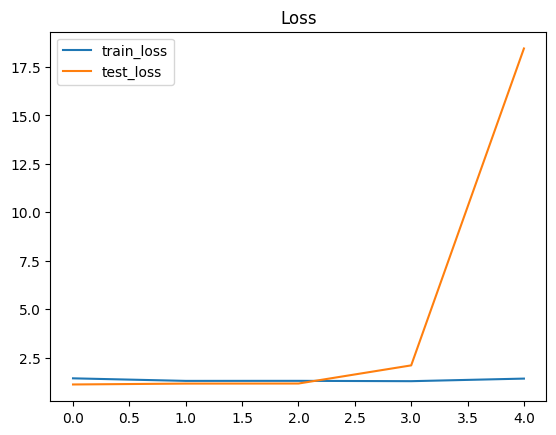

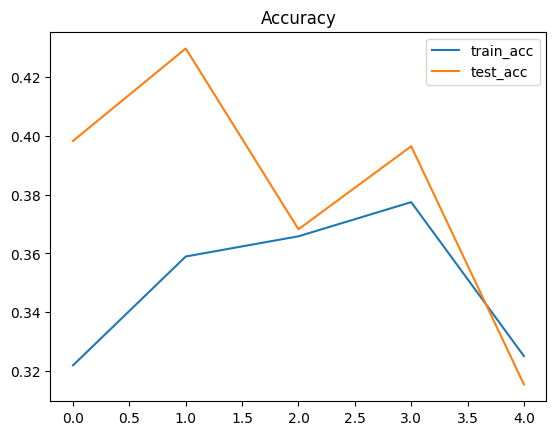

In [13]:

# 10) RUN EXPERIMENT (EDIT THESE)

DATASET = "cifar10"     # "mnist" | "fashion-mnist" | "cifar10"
MODEL   = "resnet50"    # "lenet5"|"alexnet"|"vgg16"|"resnet50"|"resnet101"|"efficientnetb0"|"inceptionv3"|"mobilenetv2"
LOSS    = "focal"       # "bce" | "focal" | "arcface" | "ce"
EPOCHS  = 5
BATCH   = 128
LR      = 1e-3
OPTIM   = "adam"        # "adam" | "sgd"

trainloader, testloader, in_ch, num_classes, img_size = get_dataloaders(DATASET, batch_size=BATCH)

use_arcface = (LOSS.lower() == "arcface")
model, feat_dim, mode = make_backbone_and_head(MODEL, in_ch, num_classes, img_size=img_size, use_arcface=use_arcface)
model = model.to(device)

# Choose criterion
loss_name = LOSS.lower()
if loss_name == "bce":
    criterion = BCEWithLogitsMulticlass(num_classes).to(device)
elif loss_name == "focal":
    criterion = FocalLoss(gamma=2.0).to(device)
elif loss_name == "arcface":
    criterion = nn.CrossEntropyLoss().to(device)  # ArcFace head outputs logits; CE works
elif loss_name == "ce":
    criterion = nn.CrossEntropyLoss().to(device)
else:
    raise ValueError("LOSS must be one of: bce, focal, arcface, ce")

# Choose optimizer
if OPTIM.lower() == "adam":
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
elif OPTIM.lower() == "sgd":
    optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9, weight_decay=5e-4)
else:
    raise ValueError("OPTIM must be: adam or sgd")

print(f"Dataset={DATASET} | Model={MODEL} | Loss={LOSS} | Optim={OPTIM} | Epochs={EPOCHS}")

history = {"train_loss":[], "train_acc":[], "test_loss":[], "test_acc":[]}

for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = train_one_epoch(model, trainloader, optimizer, criterion, classifier_mode=mode)
    te_loss, te_acc = evaluate(model, testloader, criterion, classifier_mode=mode)
    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["test_loss"].append(te_loss)
    history["test_acc"].append(te_acc)
    print(f"Epoch {epoch:02d} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | test loss {te_loss:.4f} acc {te_acc:.4f}")

# Plot curves
plt.figure()
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["test_loss"], label="test_loss")
plt.legend(); plt.title("Loss"); plt.show()

plt.figure()
plt.plot(history["train_acc"], label="train_acc")
plt.plot(history["test_acc"], label="test_acc")
plt.legend(); plt.title("Accuracy"); plt.show()


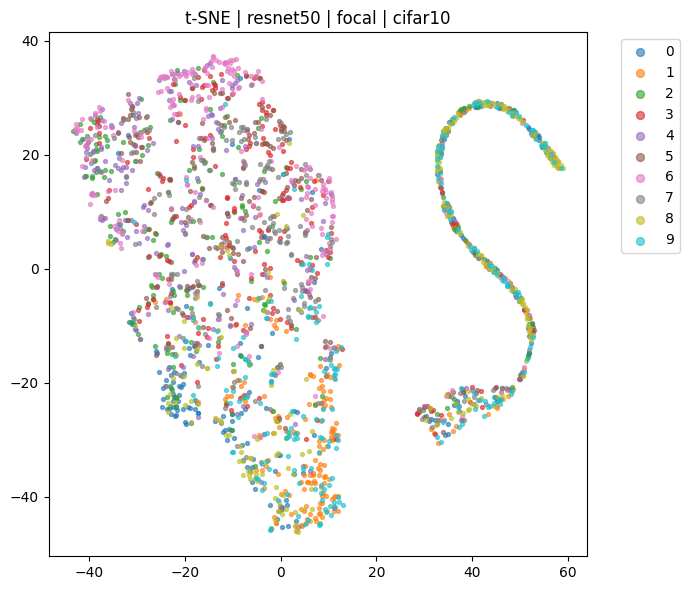

In [14]:

# 11) t-SNE (Part 3)

# Extract features from test set and visualize clustering
features, labels = extract_features(model, testloader, classifier_mode=mode, max_samples=2000)
plot_tsne(features, labels, title=f"t-SNE | {MODEL} | {LOSS} | {DATASET}")